In [1]:
from collections import namedtuple
from os import listdir

import matplotlib.pyplot as plt
import ipywidgets as widgets
import pandas as pd
import numpy as np

# Atom structure

In [2]:
Atom = namedtuple('Atom', ['name', 'element', 'aminoacid', 'x', 'y', 'z'])

Atom.parse_name = lambda string: string[12:16].strip()
Atom.parse_element = lambda string: string[12] if len(string.strip()) < 78 \
                     else string[76:78].strip()
Atom.parse_aminoacid = lambda string: string[17:20].strip()
Atom.parse_x = lambda string: float(string[30:38].strip())
Atom.parse_y = lambda string: float(string[38:46].strip())
Atom.parse_z = lambda string: float(string[46:54].strip())

Atom.parse = lambda string: Atom(
    Atom.parse_name(string), Atom.parse_element(string), Atom.parse_aminoacid(string),
    Atom.parse_y(string), Atom.parse_x(string), Atom.parse_z(string))

## Select the molecule to compare

In [3]:
path_molecules_to_compare = [f for f in listdir() 
                             if 'reference' not in f and f.endswith('.pdb')]
print(path_molecules_to_compare)

['1ACW-01.pdb', '1ACW-02.pdb', '1ACW-03.pdb', '1ACW-04.pdb', '1ACW-05.pdb', '1ACW-06.pdb']


## Read data from pdb file

In [4]:
def read_molecule(path):
    atoms = []
    with open(path, 'r') as f:
        for line in f:
            if line.startswith('ATOM'):
#                 print(line)
                try:
                    atoms.append(Atom.parse(line))
                except Exception as e:
                    print(e)
    return atoms

In [5]:
reference = pd.DataFrame(read_molecule('reference.pdb'))
molecules_to_compare = [pd.DataFrame(read_molecule(m)) \
                        for m in path_molecules_to_compare]

In [6]:
molecules_to_compare[0][:10]

,name,element,aminoacid,x,y,z
0,N,N,VAL,-2.044,-1.352,0.000
1,H1,H,VAL,-1.261,-1.990,0.000
2,H2,H,VAL,-2.540,-1.446,0.875
3,H3,H,VAL,-2.540,-1.446,-0.875
4,CA,C,VAL,-1.523,0.000,0.000
5,HA,H,VAL,-1.871,0.524,0.890
6,CB,C,VAL,-1.989,0.768,-1.232
7,HB,H,VAL,-3.078,0.814,-1.241
8,CG1,C,VAL,-1.500,0.056,-2.490
9,HG11,H,VAL,-0.411,0.010,-2.481


In [7]:
reference[:10]

,name,element,aminoacid,x,y,z
0,N,N,VAL,0.298,0.965,-0.467
1,CA,C,VAL,0.250,1.811,-1.701
2,C,C,VAL,0.400,3.290,-1.320
3,O,O,VAL,1.053,3.628,-0.346
4,CB,C,VAL,1.384,1.417,-2.664
5,CG1,C,VAL,1.262,-0.064,-3.035
6,CG2,C,VAL,2.744,1.666,-2.002
7,H1,H,VAL,1.180,1.151,0.051
8,H2,H,VAL,0.255,-0.040,-0.731
9,H3,H,VAL,-0.512,1.196,0.142


# RMSD calculation

* We can notice that the reference structure has a greater number of alpha carbons and amino acids residues.


* One approach to tackle this problem would be to `trim` the reference molecule so it will have the same amount of alpha carbons than the molecule to compare.


a) At first, we'll compute the RMSD using the beginning of the molecule reference. 



b) After, the same study will be made with the possibility of translations in the molecule to be compared. 

In [8]:
def apply_transformations(transformation, df):
    homogeneous_coordinates = df[['x', 'y', 'z']].copy()
    homogeneous_coordinates['_'] = 1.0
    return transformation.dot(homogeneous_coordinates.values.T).T
    
def RMSD(molecule1, molecule2, functions=['CA'], 
         transformation1=np.eye(4), transformation2=np.eye(4)):
    molecule1 = molecule1[molecule1.name.isin(functions)].copy()
    molecule1 = apply_transformations(transformation1, molecule1)

    molecule2 = molecule2[molecule2.name.isin(functions)].copy()
    molecule2 = apply_transformations(transformation2, molecule2)
    
    smaller_size = min(len(molecule1), len(molecule2))
    squared_differences = (molecule1[:smaller_size] - \
                           molecule2[:smaller_size]) ** 2

    squared_distance = squared_differences.sum(axis=1)
    average_squared_distance = squared_distance.mean()
    average_distance = np.sqrt(average_squared_distance)
    return average_distance

## No Translation

Not applying any transfomation.
RMSD between the reference and molecule 1: 23.519198 Ångströns
RMSD between the reference and molecule 2: 35.708949 Ångströns
RMSD between the reference and molecule 3: 23.615692 Ångströns
RMSD between the reference and molecule 4: 20.787576 Ångströns
RMSD between the reference and molecule 5: 22.118981 Ångströns
RMSD between the reference and molecule 6: 25.326716 Ångströns


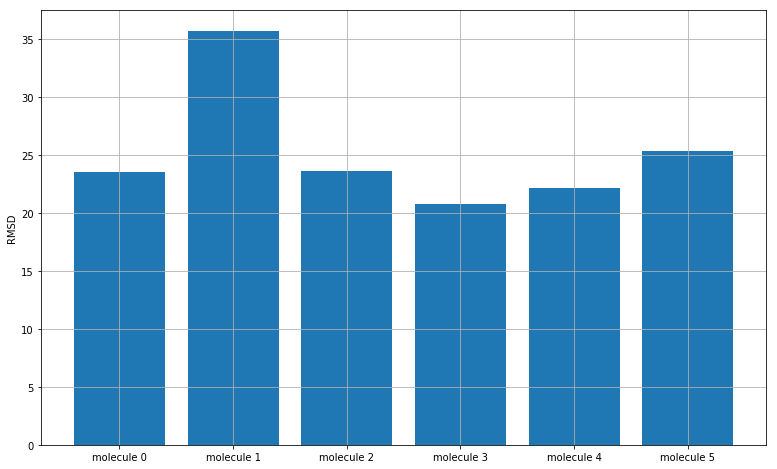

In [9]:
print('Not applying any transfomation.')
rmsd = []
labels = []
for idx, molecule_to_compare in enumerate(molecules_to_compare):
    rmsd.append(RMSD(reference, molecules_to_compare[idx]))
    labels.append('molecule %d' % idx)
    print('RMSD between the reference and molecule %d: %f Ångströns' % \
          (idx + 1, rmsd[-1]))
    

plt.figure(figsize=(13, 8))
plt.ylabel('RMSD')
plt.bar(labels, rmsd)
plt.grid()
plt.show()

## With translation.

In [10]:
def infer_translation_matrix(molecule_to_be_displaced, ref_point):
    atom_to_displace =\
        molecule_to_be_displaced[molecule_to_be_displaced.name == 'CA'].iloc[0]
    
    T_MATRIX = np.eye(4)
    T_MATRIX[0, 3] = (ref_point.x - atom_to_displace.x)
    T_MATRIX[1, 3] = (ref_point.y - atom_to_displace.y)
    T_MATRIX[2, 3] = (ref_point.z - atom_to_displace.z)
    return T_MATRIX

* At first, we'll consider as a reference point the first carbon alpha of the molecule reference.

In [11]:
ref_point = reference[reference.name == 'CA'].iloc[0]

RMSD between the reference and molecule 1: 23.214202 Ångströns
RMSD between the reference and molecule 2: 33.803276 Ångströns
RMSD between the reference and molecule 3: 24.416573 Ångströns
RMSD between the reference and molecule 4: 19.721576 Ångströns
RMSD between the reference and molecule 5: 23.510216 Ångströns
RMSD between the reference and molecule 6: 25.992975 Ångströns


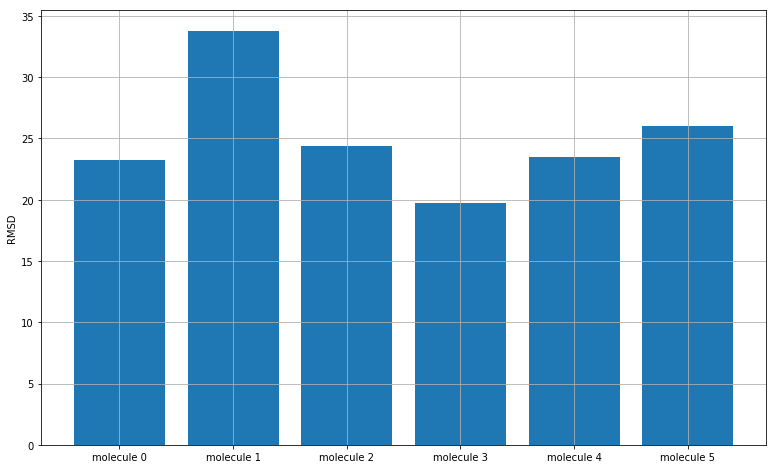

In [12]:
rmsd = []
labels = []
for idx, molecule_to_compare in enumerate(molecules_to_compare):
    translation = infer_translation_matrix(molecule_to_compare, ref_point)
    rmsd.append(RMSD(reference, molecules_to_compare[idx], transformation2=translation))
    labels.append('molecule %d' % idx)
    print('RMSD between the reference and molecule %d: %f Ångströns' % \
          (idx + 1, rmsd[-1]))
    

plt.figure(figsize=(13, 8))
plt.ylabel('RMSD')
plt.bar(labels, rmsd)
plt.grid()
plt.show()